# A Step-by-Step Guide to the Data Analysis Process
1. Import needed libraries
2. Assess data
    - Check for duplicates
    - Check for null entries
    - Check the stats
    - Select necessary data 
3. Clean data if necessary
    - Drop null entries if necessary
    - Drop duplicates if necessary
    - Clean text if necessary
4. Analyse Data
    - Check the relationship between the features
5. Select features and labels
6. Preprocess the data for the model
    - Label encoding
7. Train model
8. Perform Predictions
9. Deploy model API

# Import necessary packages and load dataset

In [1]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import spacy
import en_core_web_sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dropout,
    Bidirectional,
    Dense,
    Embedding,
)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/justice.csv')

In [3]:
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [4]:
df.shape

(3303, 16)

### 5% missing data rule

In [5]:
df.isna().sum()

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [6]:
threshold = len(df) * 0.05
threshold

165.15

In [7]:
df.columns[(df.isna().sum() > 0) & (df.isna().sum() <= threshold)]

Index(['first_party', 'second_party', 'first_party_winner', 'decision_type',
       'disposition', 'issue_area'],
      dtype='object')

In [8]:
cols_to_drop = df.columns[(df.isna().sum() > 0) \
                               & (df.isna().sum() <= threshold)]

In [9]:
df.dropna(subset=cols_to_drop, inplace=True)
df.shape

(3098, 16)

In [10]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.shape

(3098, 15)

In [11]:
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
1,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
2,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
3,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
4,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


# Data Wrangling

In [12]:
df.columns

Index(['ID', 'name', 'href', 'docket', 'term', 'first_party', 'second_party',
       'facts', 'facts_len', 'majority_vote', 'minority_vote',
       'first_party_winner', 'decision_type', 'disposition', 'issue_area'],
      dtype='object')

In [13]:
df.decision_type.value_counts()

majority opinion                     2723
per curiam                            211
plurality opinion                     145
equally divided                        12
dismissal - improvidently granted       3
dismissal - other                       2
dismissal - moot                        1
opinion of the court                    1
Name: decision_type, dtype: int64

In [14]:
df.disposition.value_counts()

reversed/remanded            1050
affirmed                      966
reversed                      562
vacated/remanded              416
reversed in-part/remanded      61
reversed in-part               19
none                           13
vacated                         6
vacated in-part/remanded        5
Name: disposition, dtype: int64

In [15]:
df_prep = df.copy()
df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
1,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
2,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
3,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
4,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [16]:
df_prep['issue_area'].value_counts()

Criminal Procedure      848
Civil Rights            561
Economic Activity       538
First Amendment         350
Judicial Power          308
Due Process             127
Federalism              125
Privacy                  69
Unions                   59
Federal Taxation         51
Attorneys                37
Miscellaneous            19
Private Action            4
Interstate Relations      2
Name: issue_area, dtype: int64

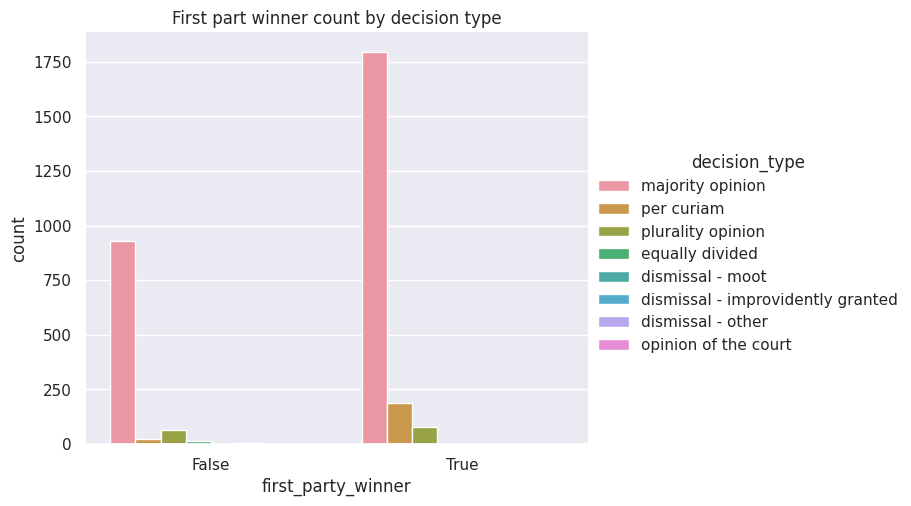

In [30]:
sns.set(font_scale=1.3)
sns.set_theme(palette = 'prism_r', style = 'darkgrid')
sns.catplot(data=df_prep,
            x='first_party_winner',
            hue='decision_type',
            kind='count',
            height=5,
            aspect=1.3).set(title='First part winner count by decision type')
plt.show()

In [21]:
df_prep.groupby('term').agg(
            Number_of_cases=('ID', 'count')
            )

,Number_of_cases
term,
1940-1955,1
1955,5
1956,18
1957,15
1958,15
...,...
2016,63
2017,69
2018,70


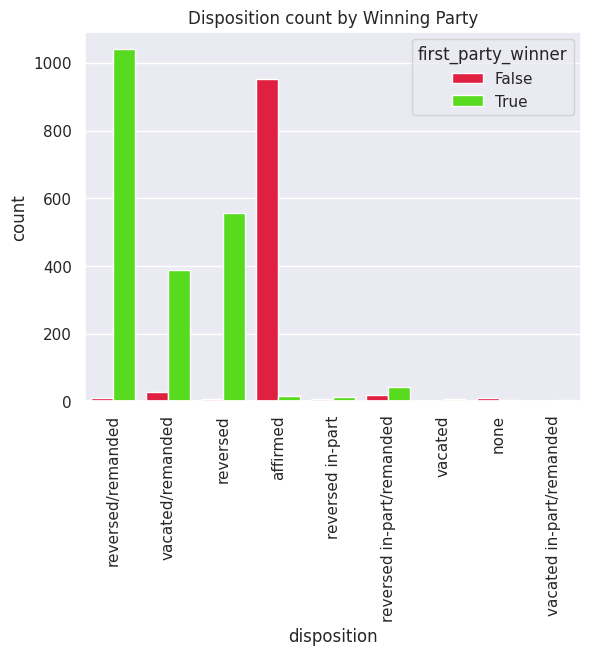

In [37]:
sns.set(font_scale=1.3)
sns.set_theme(palette = 'prism_r', style = 'darkgrid')
sns.countplot(data = df_prep, 
              x = 'disposition',
              hue = 'first_party_winner'). \
                set(title='Disposition count by Winning Party')
plt.xticks(rotation = 90)
plt.show()

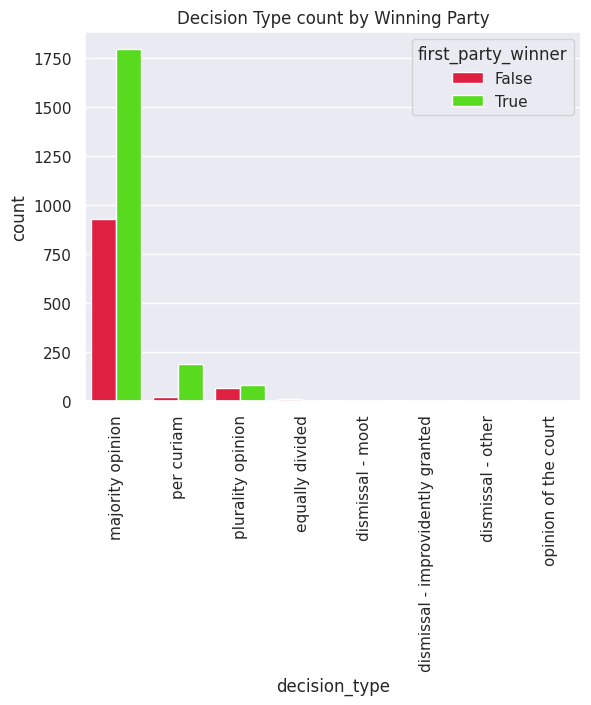

In [38]:
sns.set(font_scale=1.3)
sns.set_theme(palette = 'prism_r', style = 'darkgrid')
sns.countplot(data = df_prep, 
              x = 'decision_type',
              hue = 'first_party_winner'). \
                set(title='Decision Type count by Winning Party')
plt.xticks(rotation = 90)
plt.show()

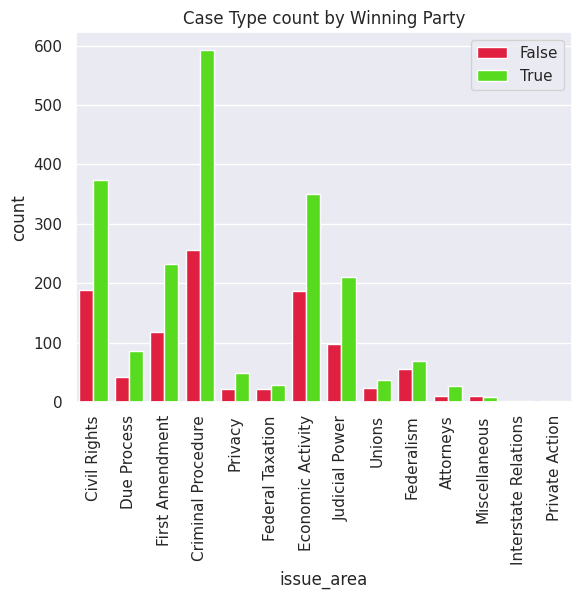

In [39]:
sns.set(font_scale=1.3)
sns.set_theme(palette = 'prism_r', style = 'darkgrid')
sns.countplot(data = df_prep, 
              x = 'issue_area',
              hue = 'first_party_winner'). \
                set(title='Case Type count by Winning Party')
plt.xticks(rotation = 90)
plt.legend(loc ='upper right')
plt.show()

# Text preprocessing

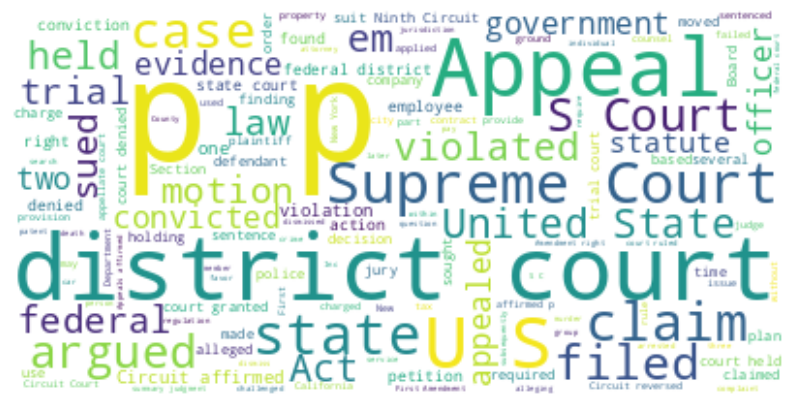

In [42]:
wordcloud = WordCloud(random_state=0, background_color="white") \
                                        .generate(' '.join(df_prep['facts']))

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show()

##### Remove English stopwords

In [43]:
def remove_stops(text, stops):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove html tags
    text = re.sub(r'<[^<>]*>', '', text)
    
    words = text.split()
    
    # Remove stopwords
    final = []
    for word in words:
        if word not in stops:
            final.append(word)
    final = ' '.join(final)
    
    # Remove punctuation
    final = final.translate(str.maketrans('', '', string.punctuation + '’'))
    final = ''.join([i for i in final if not i.isdigit()])
    
    # Remove double whitespace
    while '  ' in final:
        final = final.replace('  ', ' ')
        
    return final

##### Remove month name from texts as it hold only date information

In [44]:
months = ['Januanry', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']


for month in months:
    print(df[df['facts'].str.contains(month)]['facts'])

Series([], Name: facts, dtype: object)
4       <p>Ernest E. Mandel was a Belgian professional...
27      <p>In 1966, D.H. Overmyer Co. entered into a c...
118     <p>On January 3, 1957, Kenneth Donaldson was c...
161     <p>On February 18, 1974, three enrolled Couer ...
189     <p>J. W. Gamble was a prisoner in the Huntingt...
                              ...                        
2971    <p>In the words of the Ninth Circuit decision ...
2975    <p>Hamid Mohamed Ahmed Ali Rehaif was present ...
2978    <p>The US Department of Defense awarded petiti...
3047    <p>In 2006, Petitioner Manfredo M. Salinas app...
3083    <p>In February 2011, Sergio Ramirez went with ...
Name: facts, Length: 65, dtype: object
16      <p>On January 4, 1967, John J. Morrissey enter...
28      <p>On July 20, 1958, intruders beat an elderly...
65      <p>Carol Jo LaFleur was a teacher at Patrick H...
94      <p>On March 11, 1973, border patrol agents sto...
176     <p>On March 6, 1975, federal prosecutors ind

In [45]:
def clean_docs(docs, months):
    stops = stopwords.words('english')
    stops = stops + months
    final = []
    for doc in docs:
        clean_doc = remove_stops(doc, stops)
        final.append(clean_doc)
    return final

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [47]:
cleaned_facts = clean_docs(df_prep['facts'], months)

In [48]:
len(df_prep)

3098

In [49]:
print(df_prep['facts'][0])

<p>Joan Stanley had three children with Peter Stanley.  The Stanleys never married, but lived together off and on for 18 years.  When Joan died, the State of Illinois took the children.  Under Illinois law, unwed fathers were presumed unfit parents regardless of their actual fitness and their children became wards of the state.  Peter appealed the decision, arguing that the Illinois law violated the Equal Protection Clause of the Fourteenth Amendment because unwed mothers were not deprived of their children without a showing that they were actually unfit parents.  The Illinois Supreme Court rejected Stanley’s Equal Protection claim, holding that his actual fitness as a parent was irrelevant because he and the children’s mother were unmarried.</p>



In [50]:
print(cleaned_facts[0])

Joan Stanley three children Peter Stanley The Stanleys never married lived together years When Joan died State Illinois took children Under Illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards state Peter appealed decision arguing Illinois law violated Equal Protection Clause Fourteenth Amendment unwed mothers deprived children without showing actually unfit parents The Illinois Supreme Court rejected Stanleys Equal Protection claim holding actual fitness parent irrelevant childrens mother unmarried


#### Lemmatization, POS

In [51]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return texts_out

In [52]:
lemmatized_facts = lemmatization(cleaned_facts)

In [53]:
print(df_prep['facts'][0])
print()
print(cleaned_facts[0])
print()
print(lemmatized_facts[0])

<p>Joan Stanley had three children with Peter Stanley.  The Stanleys never married, but lived together off and on for 18 years.  When Joan died, the State of Illinois took the children.  Under Illinois law, unwed fathers were presumed unfit parents regardless of their actual fitness and their children became wards of the state.  Peter appealed the decision, arguing that the Illinois law violated the Equal Protection Clause of the Fourteenth Amendment because unwed mothers were not deprived of their children without a showing that they were actually unfit parents.  The Illinois Supreme Court rejected Stanley’s Equal Protection claim, holding that his actual fitness as a parent was irrelevant because he and the children’s mother were unmarried.</p>


Joan Stanley three children Peter Stanley The Stanleys never married lived together years When Joan died State Illinois took children Under Illinois law unwed fathers presumed unfit parents regardless actual fitness children became wards sta

### TF-IDF Vectorizer to account for word importance

In [54]:
# Code comes from the Tfidf docs online
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
vectorizer = TfidfVectorizer(
                    lowercase=True, # lowercase characters
                    max_features=50,
                    max_df=0.8,
                    min_df=5,
                    ngram_range=(1,3),
                    stop_words='english' # Get rid of stopwords the second time for assurance
                    )

In [55]:
vectors = vectorizer.fit_transform(lemmatized_facts)
vectors.toarray()[0]

array([0.        , 0.        , 0.        , 0.24922864, 0.        ,
       0.26789953, 0.        , 0.        , 0.26410811, 0.        ,
       0.        , 0.        , 0.32884639, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2253561 , 0.        , 0.        ,
       0.        , 0.        , 0.59824586, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.25052145, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.28165269, 0.        , 0.37074138])

## Label-encode target variable (`first_party_winner`)

In [56]:
df_prep['first_party_winner'] = LabelEncoder().fit_transform(df_prep['first_party_winner'])
df_prep.head()

,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,1,majority opinion,reversed/remanded,Civil Rights
1,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,1,majority opinion,reversed/remanded,Due Process
2,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,1,majority opinion,reversed/remanded,Civil Rights
3,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,1,majority opinion,vacated/remanded,First Amendment
4,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,1,majority opinion,reversed,First Amendment


In [57]:
df_prep['first_party_winner'].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

# PCA Transformation

In [58]:
df_cat = df_prep[['first_party_winner']]
df_cat.head()

,first_party_winner
0,1
1,1
2,1
3,1
4,1


In [59]:
arr = vectors.toarray()
dataframe = pd.DataFrame(data=arr, columns=vectorizer.get_feature_names_out())
dataframe.head()

,action,affirm,allege,appeal,apply,argue,case,charge,claim,convict,...,sentence,state,statute,sue,suit,trial,use,violate,violation,year
0,0.0,0.00000,0.0,0.249229,0.000000,0.2679,0.0,0.0,0.264108,0.000000,...,0.0,0.250521,0.000000,0.0,0.0,0.000000,0.000000,0.281653,0.0,0.370741
1,0.0,0.20668,0.0,0.213976,0.000000,0.0000,0.0,0.0,0.000000,0.293184,...,0.0,0.000000,0.000000,0.0,0.0,0.265606,0.000000,0.000000,0.0,0.000000
2,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.476681,...,0.0,0.000000,0.549408,0.0,0.0,0.000000,0.000000,0.393161,0.0,0.000000
4,0.0,0.00000,0.0,0.000000,0.302744,0.0000,0.0,0.0,0.000000,0.000000,...,0.0,0.205648,0.323086,0.0,0.0,0.000000,0.277626,0.000000,0.0,0.000000


In [60]:
dataframe = pd.concat([dataframe, df_cat], axis=1, join='inner')
dataframe.head()

,action,affirm,allege,appeal,apply,argue,case,charge,claim,convict,...,state,statute,sue,suit,trial,use,violate,violation,year,first_party_winner
0,0.0,0.00000,0.0,0.249229,0.000000,0.2679,0.0,0.0,0.264108,0.000000,...,0.250521,0.000000,0.0,0.0,0.000000,0.000000,0.281653,0.0,0.370741,1
1,0.0,0.20668,0.0,0.213976,0.000000,0.0000,0.0,0.0,0.000000,0.293184,...,0.000000,0.000000,0.0,0.0,0.265606,0.000000,0.000000,0.0,0.000000,1
2,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1
3,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.476681,...,0.000000,0.549408,0.0,0.0,0.000000,0.000000,0.393161,0.0,0.000000,1
4,0.0,0.00000,0.0,0.000000,0.302744,0.0000,0.0,0.0,0.000000,0.000000,...,0.205648,0.323086,0.0,0.0,0.000000,0.277626,0.000000,0.0,0.000000,1


##### One-hot encode `issue_area` feature

In [61]:
df_issue = pd.get_dummies(df['issue_area'])
dataframe = pd.concat([dataframe, df_issue], axis=1, join='inner')
dataframe.head()

,action,affirm,allege,appeal,apply,argue,case,charge,claim,convict,...,Economic Activity,Federal Taxation,Federalism,First Amendment,Interstate Relations,Judicial Power,Miscellaneous,Privacy,Private Action,Unions
0,0.0,0.00000,0.0,0.249229,0.000000,0.2679,0.0,0.0,0.264108,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.20668,0.0,0.213976,0.000000,0.0000,0.0,0.0,0.000000,0.293184,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.00000,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.000000,0.476681,...,0,0,0,1,0,0,0,0,0,0
4,0.0,0.00000,0.0,0.000000,0.302744,0.0000,0.0,0.0,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0


In [62]:
dataframe.shape

(3098, 65)

In [63]:
X = dataframe.drop(columns=['first_party_winner'])
y = dataframe['first_party_winner']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

In [64]:
pca = PCA(n_components=64)
pca_fit = pca.fit_transform(X_train)
pca_fit.shape

(2478, 64)

In [65]:
pca_df = pd.DataFrame(data = pca_fit)
pca_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.486781,0.695850,-0.248074,-0.021914,0.108905,-0.241983,0.145053,-0.133563,-0.110429,-0.042647,...,0.060274,-0.068075,-0.100849,0.016650,-0.134970,0.077334,-0.023673,0.003277,-0.005625,8.333239e-15
1,-0.329903,-0.658684,-0.464052,-0.095146,-0.182873,0.098367,-0.001241,-0.000049,-0.074616,-0.229055,...,0.151253,-0.060916,-0.182414,0.054500,0.003243,0.021554,-0.045208,0.005950,-0.002170,-3.324309e-15
2,0.809220,0.023973,-0.092246,-0.006846,-0.074706,0.136285,-0.105958,0.188460,0.042339,-0.002354,...,0.002391,0.107420,-0.159487,-0.016071,-0.047415,0.130058,0.008123,0.001403,-0.000121,-2.854410e-15


In [66]:
final_data = pd.concat([pca_df,y], axis=1, join='inner')
X_train = final_data.drop(columns=['first_party_winner'])
y_train = final_data[['first_party_winner']]

In [67]:
n_unique_words = 5000
maxlen = 64
batch_size = 32

# Neural Network

In [68]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [69]:
history=model.fit(X_train, y_train,
           batch_size=batch_size,
           epochs=150,
           validation_data=[X_test, y_test])

Epoch 1/150
78/78 [==============================] - 11s 24ms/step - loss: 0.6465 - accuracy: 0.6614 - val_loss: 0.6456 - val_accuracy: 0.6532
Epoch 2/150
78/78 [==============================] - 1s 11ms/step - loss: 0.6422 - accuracy: 0.6614 - val_loss: 0.6477 - val_accuracy: 0.6532
Epoch 3/150
78/78 [==============================] - 1s 12ms/step - loss: 0.6419 - accuracy: 0.6614 - val_loss: 0.6457 - val_accuracy: 0.6532
Epoch 4/150
78/78 [==============================] - 1s 10ms/step - loss: 0.6418 - accuracy: 0.6614 - val_loss: 0.6468 - val_accuracy: 0.6532
Epoch 5/150
78/78 [==============================] - 1s 11ms/step - loss: 0.6420 - accuracy: 0.6614 - val_loss: 0.6471 - val_accuracy: 0.6532
Epoch 6/150
78/78 [==============================] - 1s 11ms/step - loss: 0.6430 - accuracy: 0.6614 - val_loss: 0.6524 - val_accuracy: 0.6532
Epoch 7/150
78/78 [==============================] - 1s 12ms/step - loss: 0.6409 - accuracy: 0.6614 - val_loss: 0.6454 - val_accuracy: 0.6532
Epoch

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 128)           640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

# Model evaluation

In [74]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss} \nTest accuracy: {accuracy*100:2f}%')

20/20 [==============================] - 0s 6ms/step - loss: 0.6458 - accuracy: 0.6532
Test loss: 0.6458255052566528 
Test accuracy: 65.322578%


# Save model and vectorizer

In [75]:
import joblib

with open("model.joblib", "wb") as f:
    joblib.dump(model, f)
  
with open("vectorizer.joblib", "wb") as f:
    joblib.dump(vectorizer, f)

In [76]:
model.save('model.h5')